In [23]:
import os
import sys
import time as t_util
import numpy as np
import cftime
import xarray as xr
import pandas as pd
import yaml
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy


In [24]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main  = file.read()

dir_data    = f'{path_main}Data/EURO-CORDEX/ANOVA_input/'
dir_scripts = f'{path_main}Scripts/'
dir_names   = f'{path_main}Scripts/Model_lists/'
dir_fig     = f'{path_main}Figures/Paper_v2/'
dir_repo    = f'{path_main}Data/RepositoryPublication/'


## Prepare variables and parameters

In [25]:
#Define cities
cities = ['Lisbon', 'Madrid', 'Barcelona', 'Rome', 'Athens', 'Istanbul', 'Sofia', 'Bucharest', 'Belgrade',
          'Zagreb', 'Milan', 'Budapest', 'Munich', 'Vienna', 'Prague', 'Paris', 'Brussels', 'Amsterdam',
          'London', 'Dublin', 'Hamburg', 'Copenhagen', 'Berlin', 'Warsaw', 'Kharkiv', 'Kyiv', 'Minsk','Vilnius', 
          'Riga', 'Moscow', 'NizhnyNovgorod', 'Kazan', 'SaintPetersburg', 'Helsinki', 'Stockholm', 'Oslo']

cities = np.array(cities)

#Define HSIs
HSIs = ['TX', 'TN']

# Load city coordinates
fname_coords = dir_scripts + 'City_coordinates.yml'
with open(fname_coords, 'r') as file:
    city_coords = yaml.safe_load(file)
    
#Define scenarios and variables
RCP = 'rcp85'

#Define models and RCPs which should be used
models = []
with open(dir_names + 'Models_CORDEX-EUR-11_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        models.append(eval(line[:-1]))

models = ['_'.join(model) for model in models]        
        
#Define warming levels
EMT_change = '3.0K' #'1.0K', '2.0K', 

N_gridcells = ''
# N_gridcells = '_3x3'


In [26]:
# City: lat, lon, elevation, at sea (yes/no)
city_geo = pd.DataFrame(columns=['lat', 'lon', 'elev', 'sea'])
city_geo.loc['Istanbul']         = [41.013611,  28.955,      40, 1]
city_geo.loc['Moscow']           = [55.75,      37.616667,  124, 0]
city_geo.loc['London']           = [51.507222,  -0.1275,     14, 0]
city_geo.loc['SaintPetersburg']  = [59.95,      30.3,        13, 1]
city_geo.loc['Berlin']           = [52.516667,  13.383333,   34, 0]
city_geo.loc['Madrid']           = [40.383333,  -3.716667,  667, 0]
city_geo.loc['Kyiv']             = [50.45,      30.523333,  168, 0]
city_geo.loc['Rome']             = [41.9,       12.5,        14, 0]
city_geo.loc['Paris']            = [48.8567,    2.3508,      34, 0]
city_geo.loc['Bucharest']        = [44.4325,    26.103889,   70, 0]
city_geo.loc['Minsk']            = [53.9,       27.566667,  198, 0]
city_geo.loc['Vienna']           = [48.2,       16.366667,  170, 0]
city_geo.loc['Hamburg']          = [53.565278,  10.001389,    6, 0]
city_geo.loc['Warsaw']           = [52.233333,  21.016667,   93, 0]
city_geo.loc['Budapest']         = [47.4925,    19.051389,  102, 0]
city_geo.loc['Barcelona']        = [41.383333,  2.183333,    12, 1]
city_geo.loc['Munich']           = [48.133333,  11.566667,  520, 0]
city_geo.loc['Kharkiv']          = [50.004444,  36.231389,  152, 0]
city_geo.loc['Milan']            = [45.466667,  9.183333,   152, 0]
city_geo.loc['Belgrade']         = [44.816667,  20.466667,  116, 0]
city_geo.loc['Prague']           = [50.083333,  14.416667,  244, 0]
city_geo.loc['NizhnyNovgorod']   = [56.326944,  44.0075,     78, 0]
city_geo.loc['Kazan']            = [55.790278,  49.134722,  116, 0]
city_geo.loc['Sofia']            = [42.7,       23.33,      580, 0]
city_geo.loc['Brussels']         = [50.8467,    4.3525,      76, 0]
city_geo.loc['Stockholm']        = [59.329444,  18.068611,   15, 1]
city_geo.loc['Oslo']             = [59.913889,  10.752222,   12, 1]
city_geo.loc['Dublin']           = [53.35,      -6.266667,    8, 1]
city_geo.loc['Lisbon']           = [38.725267,  -9.150019,   15, 1]
city_geo.loc['Vilnius']          = [54.683333,  25.283333,  124, 0]
city_geo.loc['Copenhagen']       = [55.676111,  12.568333,    5, 1]
city_geo.loc['Helsinki']         = [60.170833,  24.9375,     25, 1]
city_geo.loc['Athens']           = [37.983972,  23.727806,  153, 1]
city_geo.loc['Amsterdam']        = [52.366667,  4.9,         -2, 1]
city_geo.loc['Riga']             = [56.948889,  24.106389,    8, 1]
city_geo.loc['Zagreb']           = [45.816667,  15.983333,  130, 0]

#Source for elevation: https://en.wikipedia.org/wiki/List_of_capital_cities_by_elevation and google

#Save data in file
city_geo.sort_index().to_excel(dir_data + 'location_cities.xlsx')


## Calculate linear regression to get R2

In [34]:
#Select methods to show in plot
methods = ['HSI-changes', 'Threshold-Exceedance', 'HWMId']

#Select which time method to use for HSI changes ('JJA_mean', 'Q90', 'Ymax')
t_method = 'Ymax'
quantile = 'Q50'

#Define threshold levels
THR_levels = dict()
THR_levels['TN'] = 2 # 20 °C
THR_levels['TX'] = 3 # 30 °C

#Read mean and standard deviation for EMT levels
fname_mean = dir_data + 'ANOVA' + N_gridcells + '_' + 'HSIs-mean_rcp85_EMT.nc'
fname_std  = dir_data + 'ANOVA' + N_gridcells + '_' + 'HSIs-SD_rcp85_EMT.nc'
data_mean  = xr.open_dataset(fname_mean)
data_std   = xr.open_dataset(fname_std)

#Read mean and standard deviatione of HSIs in reference period
fname_ref_mean = dir_data + 'ANOVA' + N_gridcells + '_' + 'HSIs-mean_' + RCP + '_time-periods.nc'
fname_ref_std  = dir_data + 'ANOVA' + N_gridcells + '_' + 'HSIs-SD_' + RCP + '_time-periods.nc'
data_ref_mean  = xr.open_dataset(fname_ref_mean)
data_ref_std   = xr.open_dataset(fname_ref_std)

#Create empty arrays
R2     = np.zeros((len(HSIs), len(methods), len(models), 15, 2)) * np.NaN
R2_adj = np.zeros((len(HSIs), len(methods), len(models), 15, 2)) * np.NaN
pvalues = np.zeros((len(HSIs), len(methods), len(models), 5, 2)) * np.NaN

#Loop over different sets of explanatory variables
for i0, exp_var in enumerate(range(0,2)):

    #Loop over HSIs
    for i1, HSI in enumerate(HSIs):

        THR_level = 'Level' + str(THR_levels[HSI])

        methods = dict()
        methods['HSI-changes']          = HSI + '_DeltaChange-' + t_method
        methods['Threshold-Exceedance'] = HSI + '_ThrExc-' + THR_level
        methods['HWMId']                = HSI + '_HWMId-' + quantile

        #Loop over methods
        for i2, method in enumerate(methods):

            #Read data
            fname_read = dir_data + 'ANOVA' + N_gridcells + '_' + methods[method] + '_all_models.csv'
            data = pd.read_csv(fname_read, index_col=0)

            #Loop over models
            for i3, model in enumerate(models):

                if exp_var==0:

                    #Get data (mean, SD, and change)
                    x1 = data_ref_mean.sel(time_period='1981-2010', model=model, drop=True)[HSI]
                    x2 = data_ref_std.sel(time_period='1981-2010', model=model, drop=True)[HSI]
                    x3 = data_mean.sel(EMT_change='3.0K', model=model, drop=True)[HSI] - data_ref_mean.sel(time_period='1981-2010', model=model, drop=True)[HSI]
                    x4 = data_std.sel(EMT_change='3.0K', model=model, drop=True)[HSI] - data_ref_std.sel(time_period='1981-2010', model=model, drop=True)[HSI]
                    x1 = x1.to_dataframe()[HSI].sort_index().to_frame(name='mean_ref')
                    x2 = x2.to_dataframe()[HSI].sort_index().to_frame(name='std_ref')
                    x3 = x3.to_dataframe()[HSI].sort_index().to_frame(name='mean_chg')
                    x4 = x4.to_dataframe()[HSI].sort_index().to_frame(name='std_chg')

                elif exp_var==1:
                
                    #Get data (mean, SD, and change)
                    x1 = city_geo['lat'].sort_index()
                    x2 = city_geo['lon'].sort_index()
                    x3 = city_geo['elev'].sort_index()
                    x4 = city_geo['sea'].sort_index()
                    
                #Define all combinations of input variables
                X = dict()
                X[0]  = x1
                X[1]  = x2
                X[2]  = x3
                X[3]  = x4
                X[4]  = pd.concat((x1, x2), axis=1)
                X[5]  = pd.concat((x1, x3), axis=1)
                X[6]  = pd.concat((x1, x4), axis=1)
                X[7]  = pd.concat((x2, x3), axis=1)
                X[8]  = pd.concat((x2, x4), axis=1)
                X[9]  = pd.concat((x3, x4), axis=1)
                X[10] = pd.concat((x1, x2, x3), axis=1)
                X[11] = pd.concat((x1, x2, x4), axis=1)
                X[12] = pd.concat((x1, x3, x4), axis=1)
                X[13] = pd.concat((x2, x3, x4), axis=1)
                X[14] = pd.concat((x1, x2, x3, x4), axis=1)

                #Get data (change, threshold exceedance, HWMId)
                y = data.loc[model]
                Y = y.to_frame(name='data').sort_index()

                #Check that all dataframes are sorted correctly
                if not np.all([np.all(x1.index==x2.index), np.all(x1.index==x3.index), np.all(x1.index==x4.index), np.all(x1.index==Y.index)]):
                    sys.exit('Order of cities does not agree')

                #Loop over all combinations of input variables
                for i4 in range(0, 15):

                    #Select explanatory variables and add constant
                    X_in = X[i4]
                    X_in = sm.add_constant(X_in)

                    #Fit linear model
                    model_SM = sm.OLS(Y, X_in).fit(use_t=True)

                    #Save R2 and R2_adj in arrays
                    R2[i1, i2, i3, i4, i0]     = model_SM.rsquared
                    R2_adj[i1, i2, i3, i4, i0] = model_SM.rsquared_adj

                    #Save p-values in array
                    if i4==14:
                        pvalues[i1, i2, i3, :, i0] = model_SM.pvalues.values


/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versio

## Calculate semipartial correlations

In [35]:
#Get all possible permutations
perms = []
for var in range(1, 5):
    perms = perms + list(itertools.combinations(range(4), var))

#Create array for storing semipartial correlations
corr_semi_parr = np.zeros(R2.shape[0:3] + (8, 4, 2,)) * np.NaN

#Loop over different sets of explanatory variables
for i0, exp_var in enumerate(range(0,2)):

    #Loop over all variables
    for index in range(0, 4):

        print("Index " + str(index) + ':')

        #Add R2 of model with only one variable
        corr_semi_parr[:, :, :, 0, index, i0] = R2[:, :, :, index, i0]

        #Loop over all permutations
        i_corr = 1
        for i_top, perm in enumerate(perms):

            #Check that at least two permutations are included
            if (index in perm) and len(perm)>1:

                perm = np.array(perm)

                #Get index of R2 that should be subtracted
                i_low = [ii for ii, perm1 in enumerate(perms) if perm1==tuple(perm[perm!=index])]
                if len(i_low)!=1:
                    sys.exit('Something went wrong')
                else:
                    i_low = i_low[0]

                #Calculate semipartial correlation and save in array
                corr_semi_parr[:, :, :, i_corr, index, i0] = R2[:, :, :, i_top, i0] - R2[:, :, :, i_low, i0]
                i_corr = i_corr + 1

                print(i_top, end = ' - ')
                print(i_low)

        print('')
    
#Dimensions of corr_semi_parr
# 0: indicators (e.g, TX, TN)
# 1: heat metrics
# 2: climate models
# 3: regression models for semipartial correlation
# 4: explanatory variables
# 5: location (1) or climate (2) factors

Index 0:
4 - 1
5 - 2
6 - 3
10 - 7
11 - 8
12 - 9
14 - 13

Index 1:
4 - 0
7 - 2
8 - 3
10 - 5
11 - 6
13 - 9
14 - 12

Index 2:
5 - 0
7 - 1
9 - 3
10 - 4
12 - 6
13 - 8
14 - 11

Index 3:
6 - 0
8 - 1
9 - 2
11 - 4
12 - 5
13 - 7
14 - 10

Index 0:
4 - 1
5 - 2
6 - 3
10 - 7
11 - 8
12 - 9
14 - 13

Index 1:
4 - 0
7 - 2
8 - 3
10 - 5
11 - 6
13 - 9
14 - 12

Index 2:
5 - 0
7 - 1
9 - 3
10 - 4
12 - 6
13 - 8
14 - 11

Index 3:
6 - 0
8 - 1
9 - 2
11 - 4
12 - 5
13 - 7
14 - 10



## Plot preparation

In [36]:
#Select methods to show in plot
methods_out = ['Change', 'Threshold\nexceedance', 'heat wave magnitude']

#Labels
labels_clim = lambda HSI: ['$\overline{\mathrm{' + HSI + '}}_{\mathrm{ref}}$', '$\sigma_{\mathrm{' + HSI + ',ref}}$', '$\Delta\overline{\mathrm{' + HSI + '}}$', '$\Delta\sigma_{\mathrm{' + HSI + '}}$']
labels_loc  = ['Latitude', 'Longitude', 'Elevation', 'Located at sea']

#Labels
names_excel = dict()
names_excel[0] = lambda HSI: [HSI + ' average', HSI + ' SD', 'Change in ' + HSI + ' average', 'Change in ' + HSI + ' SD']
names_excel[1] = lambda HSI: ['Latitude', 'Longitude', 'Elevation', 'Located at sea']

#Colors and hatching
colors_clim = ['#fee0d2', '#fc9272', '#ef3b2c', '#a50f15']
colors_loc  = ['#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8']

THR_levels_vals = dict()
THR_levels_vals['TN_Level2'] = '20'
THR_levels_vals['TX_Level3'] = '30'

letters = ['a)', 'b)']

#Titles 2
titles = dict()
titles['HSI-changes'] = lambda HSI, THR_level : HSI + 'x change'
titles['Threshold-Exceedance'] = lambda HSI, THR_level: 'Exceedance\n' + HSI + '>' + THR_levels_vals[HSI + '_' + THR_level] + '°C'
titles['HWMId'] = lambda HSI, THR_level : 'HWMId-' + HSI

titles2 = dict()
titles2[0] = 'Climate factors'
titles2[1] = 'Location factors'


## Plot


HSI-changes
0.5833276941387092

Threshold-Exceedance
0.7791165765893644

HWMId
0.41522775954432767

HSI-changes
0.502974624209555

Threshold-Exceedance
0.5928666392911173

HWMId
0.19398720672538972

HSI-changes
0.609159274480932

Threshold-Exceedance
0.8249563308219717

HWMId
0.5818665600089752

HSI-changes
0.51865614480251

Threshold-Exceedance
0.8654009837199754

HWMId
0.3064580120271629


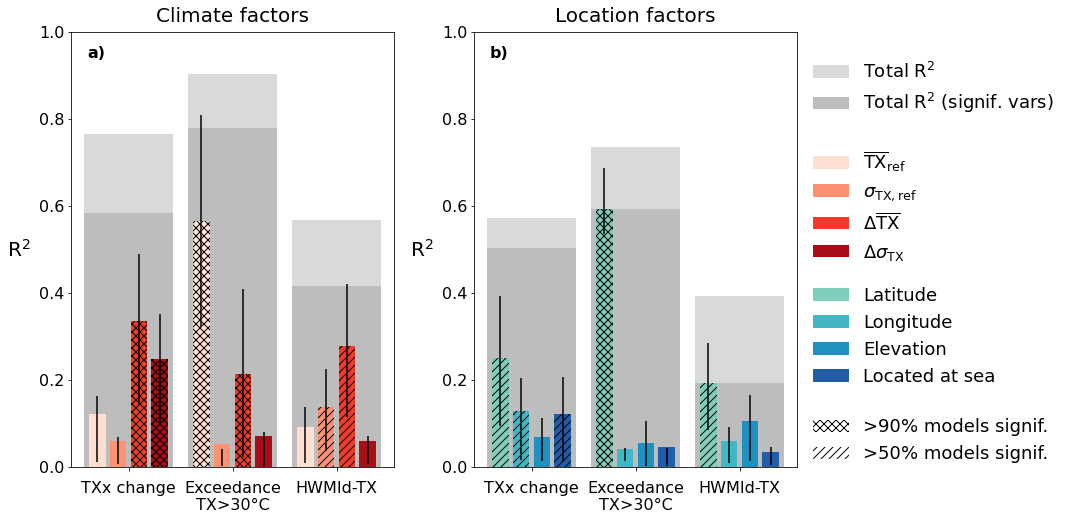

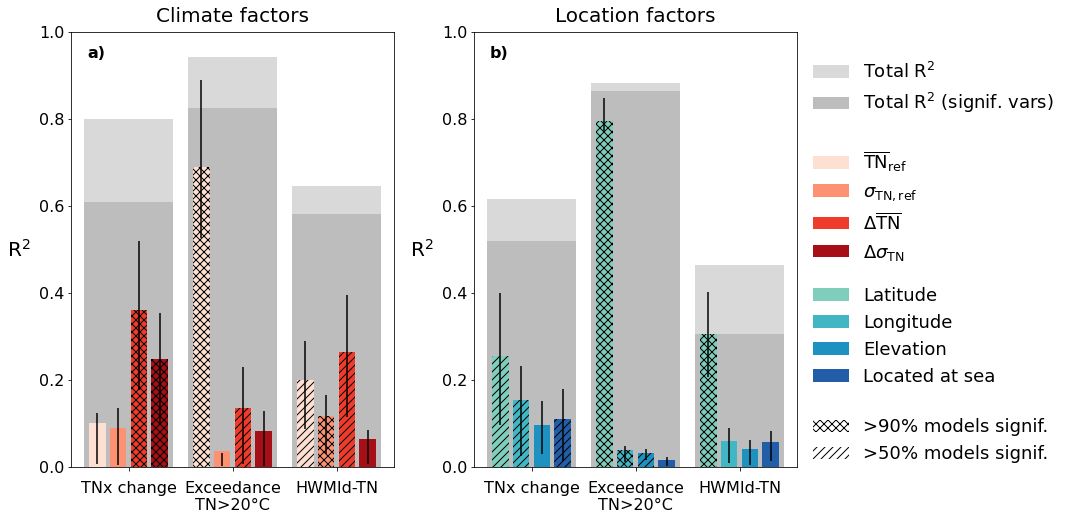

In [37]:
# Array for collecting data to store in excel
coll_data_out = dict()

#Loop over HSIs
p_clim = []
p_loc  = []
for i1, HSI in enumerate(HSIs):
    
    #Create figure
    fig, axes = plt.subplots(1, 2, figsize=(13, 8))
    plt.subplots_adjust(wspace=0.25)

    #Loop over different sets of explanatory variables
    for i0, exp_var in enumerate(range(0,2)):

        ax = axes[i0]
        
        x_labels = []
        
        #Loop over methods
        for i2, method in enumerate(methods):

            print('')
            print(method)
            
            THR_level = 'Level' + str(THR_levels[HSI])
            x_labels.append(titles[method](HSI, THR_level))

            if exp_var==0:
                colors = colors_clim
                labels = labels_clim

            else:
                colors = colors_loc
                labels = labels_loc            
            
            #Get total R2
            R2_tot = corr_semi_parr[i1, i2, :, :, :, i0].sum(axis=2)
            R2_tot = R2_tot.mean()

            #Get total R2 of significant variables only
            p_sel = pvalues[i1, i2, :, :, i0]
            p_sel = np.sum(p_sel<0.05, axis=0) / np.shape(p_sel)[0]
            sel = p_sel[1::]>0.5
            R2_sign = corr_semi_parr[i1, i2, :, :, :, i0]
            R2_sign = R2_sign[:, :, sel].sum(axis=2).mean()        

            print(R2_sign)
            
            #Plot total R2
            p_R2a = ax.bar(i2*5 + 1.5, R2_tot, width=4.25, color='#d9d9d9')
            p_R2b = ax.bar(i2*5 + 1.5, R2_sign, width=4.25, color='#bdbdbd')

            ##Loop over explanatory variables
            S_tot = 0
            for index in range(0, 4):

                #Get semipartial correlation
                semi_sel = corr_semi_parr[i1, i2, :, :, index, i0]

                S_mean = semi_sel.mean()

                #Get p-values
                p_sel = pvalues[i1, i2, :, index + 1, i0]
                p_sel = np.sum(p_sel<0.05) / len(p_sel)

                #Define hatching based on p-values
                if p_sel>0.9:    hatch = 'xxx'
                elif p_sel>0.5:  hatch = '///'
                else:            hatch = ''

                #Get 25th and 75th percentile and create IQR
                q25 = np.array(np.quantile(semi_sel, 0.25))
                q75 = np.array(np.quantile(semi_sel, 0.75))
                yerr = [S_mean - q25, q75 - S_mean]
                yerr = np.expand_dims(np.array(yerr), axis=1)

                #Plot individual R2 and uncertainty (IQR)
                ax.bar(i2*5 + index, S_mean, color=colors[index], hatch=hatch)
                ax.errorbar(i2*5 + index, S_mean, yerr=yerr, color='k')

                coll_data_out[HSI + '_' + method + '_' + titles2[i0] + '_' + names_excel[i0](HSI)[index]] = S_mean
                
                if i1==0 and i2==0:
                    p_help = ax.bar(200, S_mean, color=colors[index])
                    if i0==0:
                        p_clim.append(p_help)
                    elif i0==1:
                        p_loc.append(p_help)

                S_tot = S_tot + S_mean  

        #Set limits, ticks, and sizes
        ax.set_xlim([-1.25, 14.25])
        ax.set_ylim([0, 1])
        ax.set_xticks(np.arange(1.5, 14, 5))
        ax.set_xticklabels(x_labels)
        ax.set_title(titles2[i0], fontsize=20, pad=10)
        ax.set_ylabel('R$^2$', rotation=0, fontsize=20, labelpad=20, va='center')
        ax.tick_params(labelsize=16)
        ax.tick_params(axis='x', which='major', pad=10)
        
        ax.text(-0.5, 0.94, letters[i0], fontweight='bold', fontsize=16)
        

    #Create legends (using dummy scatter plots)
    p_help1 = ax.bar(200, 50, color='w', hatch='xxx')
    p_help2 = ax.bar(200, 50, color='w', hatch='///')
    
    #Create legends
    leg1 = ax.legend([p_R2a[0], p_R2b[0]], ['Total R$^2$', 'Total R$^2$ (signif. vars)'], fontsize=18, loc=6, bbox_to_anchor=(1, 0.87), ncol=1, frameon=False)
    leg2 = ax.legend(p_clim, labels_clim(HSI), fontsize=18, loc=6, bbox_to_anchor=(1, 0.6), ncol=1, frameon=False)
    leg3 = ax.legend(p_loc, labels_loc, fontsize=18, loc=6, bbox_to_anchor=(1, 0.3), ncol=1, frameon=False)
    leg4 = ax.legend([p_help1, p_help2], ['>90% models signif.', '>50% models signif.'], fontsize=18, loc=6, bbox_to_anchor=(1, 0.06), ncol=1, frameon=False)
    ax.add_artist(leg1)
    ax.add_artist(leg2)
    ax.add_artist(leg3)

    #Save figure
    if N_gridcells=='' and HSI=='TX':
        plt.savefig(dir_fig + 'Fig5_ANOVA' + N_gridcells + '_' + HSI + '_v2.png', bbox_inches='tight', dpi=300)
    else:
        plt.savefig(dir_fig + 'FigS_ANOVA' + N_gridcells + '_' + HSI + '_v2.png', bbox_inches='tight', dpi=300)


## Export data to excel

In [9]:
#Define HSI and threshold level
HSI ='TX'
THR_level = 'Level' + str(THR_levels[HSI])

#Define factors
factors = ['Climate factors', 'Location factors']

#Define output file name
fname_out = dir_repo + 'Data_Fig5_Contribution-of-explanatory-variables-to-total-explained-variance.xlsx'
if os.path.exists(fname_out):  os.remove(fname_out)

#Create excel file
with pd.ExcelWriter(fname_out, mode="w") as writer:

    #Loop over factors
    for i0, factor in enumerate(factors):
    
        #Create data frame
        data_out = pd.DataFrame(columns = methods)
    
        #Loop over methods
        for method in methods:

            #Get title
            name = titles[method](HSI, THR_level)

            #Loop over explanatory variables
            for index in range(0, 4):
            
                #Get name of explanatory variables
                expl_variab = names_excel[i0](HSI)[index]

                #Extract data and save in output dataframe
                data = coll_data_out[HSI + '_' + method + '_' + factor + '_' + expl_variab]
                data_out.loc[expl_variab, method] = data
                
                #Add index name
                data_out.index = data_out.index.rename('Explained variance of each explanatory variable')
                
                #Save in file
                data_out.to_excel(writer, sheet_name=factor, float_format="%.3f")


## Plot (old)

In [10]:
# # Array for collecting data to store in excel
# coll_data_out = dict()

# #Loop over HSIs
# p_clim = []
# p_loc  = []
# for i1, HSI in enumerate(HSIs):
    
#     #Create figure
#     fig, axes = plt.subplots(1, 3, figsize=(10, 8))
#     plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
#     #Loop over methods
#     for i2, method in enumerate(methods):
        
#         ax = axes[i2]
        
#         print('')
#         print(method)
        
#         #Loop over different sets of explanatory variables
#         for i0, exp_var in enumerate(range(0,2)):

#             if exp_var==0:
#                 colors = colors_clim
#                 labels = labels_clim

#             else:
#                 colors = colors_loc
#                 labels = labels_loc            
            
#             #Get total R2
#             R2_tot = corr_semi_parr[i1, i2, :, :, :, i0].sum(axis=2)
#             R2_tot = R2_tot.mean()

#             #Get total R2 of significant variables only
#             p_sel = pvalues[i1, i2, :, :, i0]
#             p_sel = np.sum(p_sel<0.05, axis=0) / np.shape(p_sel)[0]
#             sel = p_sel[1::]>0.5
#             R2_sign = corr_semi_parr[i1, i2, :, :, :, i0]
#             R2_sign = R2_sign[:, :, sel].sum(axis=2).mean()        

#             print(R2_sign)
            
#             #Plot total R2
#             p_R2a = ax.bar(5*i0 + 1.5, R2_tot, width=4.25, color='#d9d9d9')
#             p_R2b = ax.bar(5*i0 + 1.5, R2_sign, width=4.25, color='#bdbdbd')

#             ##Loop over explanatory variables
#             S_tot = 0
#             for index in range(0, 4):

#                 #Get semipartial correlation
#                 semi_sel = corr_semi_parr[i1, i2, :, :, index, i0]

#                 S_mean = semi_sel.mean()

#                 #Get p-values
#                 p_sel = pvalues[i1, i2, :, index + 1, i0]
#                 p_sel = np.sum(p_sel<0.05) / len(p_sel)

#                 #Define hatching based on p-values
#                 if p_sel>0.9:    hatch = 'xxx'
#                 elif p_sel>0.5:  hatch = '///'
#                 else:            hatch = ''

#                 #Get 25th and 75th percentile and create IQR
#                 q25 = np.array(np.quantile(semi_sel, 0.25))
#                 q75 = np.array(np.quantile(semi_sel, 0.75))
#                 yerr = [S_mean - q25, q75 - S_mean]
#                 yerr = np.expand_dims(np.array(yerr), axis=1)


#                 #Plot individual R2 and uncertainty (IQR)
#                 ax.bar(5 * i0 + index, S_mean, color=colors[index], hatch=hatch)
#                 ax.errorbar(5 * i0 + index, S_mean, yerr=yerr, color='k')

#                 coll_data_out[HSI + '_' + method + '_' + titles2[i0] + '_' + names_excel[i0](HSI)[index]] = S_mean
                
#                 if i1==0 and i2==0:
#                     p_help = ax.bar(200, S_mean, color=colors[index])
#                     if i0==0:
#                         p_clim.append(p_help)
#                     elif i0==1:
#                         p_loc.append(p_help)

#                 S_tot = S_tot + S_mean  

#         #Set limits, ticks, and sizes
#         ax.set_xlim([-1.25, 9.25])
#         ax.set_ylim([0, 1])
#         ax.set_xticks(np.arange(1.5, 8, 5))
#         ax.set_xticklabels(['Climate', 'Location'])
#         ax.set_title(titles[method](HSI, 'Level' + str(THR_levels[HSI])), fontsize=16, pad=10)
#         if i2!=0:  ax.set_yticks([])
#         else:      ax.set_ylabel('R$^2$', rotation=0, fontsize=20, labelpad=20)
#         ax.tick_params(labelsize=16)
#         ax.tick_params(axis='x', which='major', pad=10)

#     #Create legends (using dummy scatter plots)
#     p_help1 = ax.bar(200, 50, color='w', hatch='xxx')
#     p_help2 = ax.bar(200, 50, color='w', hatch='///')
    
#     #Create legends
#     leg1 = ax.legend([p_R2a[0], p_R2b[0]], ['Total R$^2$', 'Total R$^2$ (signif. vars)'], fontsize=18, loc=6, bbox_to_anchor=(1, 0.87), ncol=1, frameon=False)
#     leg2 = ax.legend(p_clim, labels_clim(HSI), fontsize=18, loc=6, bbox_to_anchor=(1, 0.6), ncol=1, frameon=False)
#     leg3 = ax.legend(p_loc, labels_loc, fontsize=18, loc=6, bbox_to_anchor=(1, 0.3), ncol=1, frameon=False)
#     leg4 = ax.legend([p_help1, p_help2], ['>90% models signif.', '>50% models signif.'], fontsize=18, loc=6, bbox_to_anchor=(1, 0.06), ncol=1, frameon=False)
#     ax.add_artist(leg1)
#     ax.add_artist(leg2)
#     ax.add_artist(leg3)

#     #Save figure
#     if N_gridcells=='' and HSI=='TX':
#         plt.savefig(dir_fig + 'Fig5_ANOVA' + N_gridcells + '_' + HSI + '.png', bbox_inches='tight', dpi=300)
#     else:
#         plt.savefig(dir_fig + 'FigSx_ANOVA' + N_gridcells + '_' + HSI + '.png', bbox_inches='tight', dpi=300)
